# Setup

In [5]:
# Load necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from pandas.plotting import register_matplotlib_converters
import joblib
import random


import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from wordcloud import WordCloud, STOPWORDS

from transformers import AutoModel
import torch
from torch import nn
from torch.nn import functional as F

%matplotlib inline
# %config InlineBackend.figure_format='svg'

register_matplotlib_converters()
# can add font_scale=1.5 if necessary
sns.set(style='whitegrid', palette='muted')

import warnings
warnings.filterwarnings('ignore')

In [2]:
# setting some visualization parameters
# plt.style.use('seaborn')
# rcparams must come after style
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [3]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
PATH = "data"
df = pd.read_csv(f'{PATH}//IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [14]:
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

In [6]:
df.loc[0, 'review']

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [ ]:
df.sentiment.value_counts()

0    25000
1    25000
Name: sentiment, dtype: int64

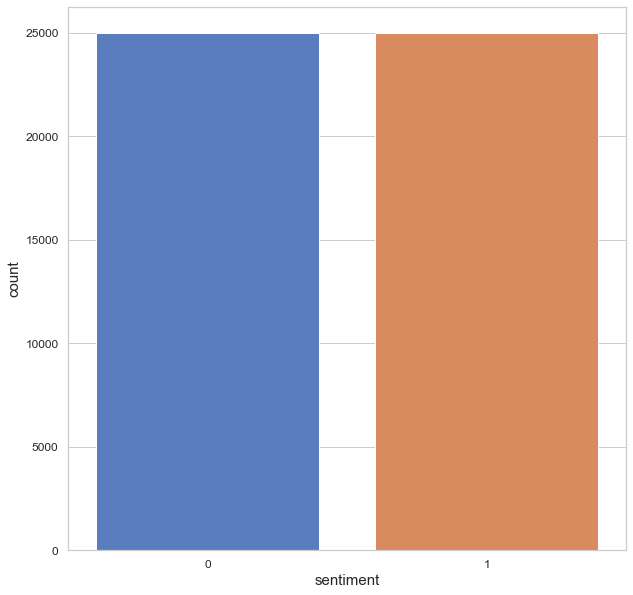

In [ ]:
sns.countplot(data=df, x='sentiment');

In [ ]:
wc_stopwords = set(STOPWORDS)
wc_stopwords.update(["br"])

In [ ]:
positive_text = df.loc[df['sentiment'] == 1, 'review']
positive_text = ' '.join(txt for txt in positive_text.values)

negative_text = df.loc[df['sentiment'] == 0, 'review']
negative_text = ' '.join(txt for txt in negative_text.values)

In [ ]:
def generate_wordcloud(txt):
    WC = WordCloud(stopwords=wc_stopwords, width=1000, height=500, max_words=500, min_font_size=5)
    wordcloud = WC.generate(txt)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

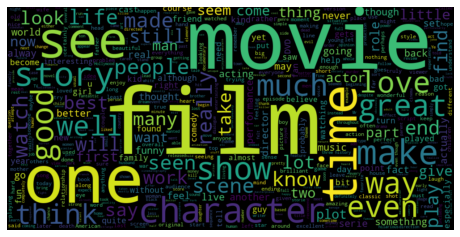

In [ ]:
generate_wordcloud(positive_text)

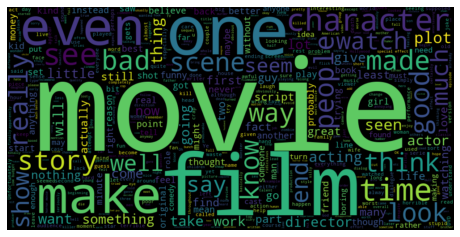

In [ ]:
generate_wordcloud(negative_text)

# Logistic Regression

In [229]:
X_train, X_test, y_train, y_test = train_test_split(df['review'],
                                                    df['sentiment'],
                                                    test_size=0.2,
                                                    random_state=42)

In [230]:
X_train.head(), y_train.head()

(39087    That's what I kept asking myself during the ma...
 30893    I did not watch the entire movie. I could not ...
 45278    A touching love story reminiscent of In the M...
 16398    This latter-day Fulci schlocker is a totally a...
 13653    First of all, I firmly believe that Norwegian ...
 Name: review, dtype: object,
 39087    0
 30893    0
 45278    1
 16398    0
 13653    0
 Name: sentiment, dtype: int64)

In [125]:
X_train.shape, y_train.shape, y_test.shape

((40000,), (40000,), (10000,))

In [126]:
stopwords_set = set(nltk_stopwords.words('english'))

In [334]:
vectorizer = TfidfVectorizer(stop_words=stopwords_set)
X_train_tf = vectorizer.fit_transform(X_train)
X_test_tf = vectorizer.transform(X_test)

In [335]:
joblib.dump(vectorizer, open('data/vectorizer.joblib', 'wb'))

In [341]:
len(vectorizer.vocabulary_)

92858

In [128]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=42)
clf.fit(X_train_tf, y_train)

LogisticRegression(random_state=42)

In [156]:
clf.score(X_train_tf, y_train)

0.934775

In [231]:
clf.score(X_test_tf, y_test)

0.8972

In [243]:
preds = clf.predict(X_test_tf)

In [244]:
from sklearn.metrics import classification_report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.91      0.88      0.89      4961
           1       0.89      0.91      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [153]:
joblib.dump(clf, open('data/logreg.joblib', 'wb'))

In [140]:
vocab_names = vectorizer.get_feature_names()
len(vocab_names)

92858

In [180]:
from sklearn.model_selection import cross_val_score, KFold
cv = KFold(n_splits=10, shuffle=True, random_state=42)
X, y = X_train_tf, y_train
cv_score = cross_val_score(clf, X, y, cv=cv)
print(np.mean(cv_score))

0.8957


In [181]:
cv_score

array([0.896  , 0.89625, 0.89   , 0.905  , 0.90275, 0.893  , 0.89475,
       0.89125, 0.89925, 0.88875])

# Checking wrong predictions

In [321]:
wrong_preds = y_test[y_test != preds]

In [322]:
wrong_preds.head()

33553    1
49498    1
6113     1
15118    1
13466    1
Name: sentiment, dtype: int64

In [313]:
wrong_preds.value_counts()

0    589
1    439
Name: sentiment, dtype: int64

In [332]:
number_of_reviews = 3
indices = [random.choice(wrong_preds.index) for _ in range(number_of_reviews)]

for idx in indices:
    txt, target = df.loc[idx]
    txt = np.array([txt])
    txt_tf = vectorizer.transform(txt)
    pred_one = clf.predict(txt_tf)[0]
    sentiment = class_names[pred_one]
    wrapped_txt = "\n".join(wrap(txt[0]))

    print(f'Review text:\n{wrapped_txt}\n')
    print(f'Actual    : {class_names[target]}')
    print(f'Predicted : {sentiment}\n')
    # break

Review text:
OhMyGAWD!!! THE MAGIC GARDEN is perhaps one of my most vivid '70s
childhood memories. Two hippie chicks with ponytails, Carole and Paula
would swing on swings, tell jokes they picked off the chuckle patch,
dress up with costumes they found in a giant chest called The
Storybox, and argue with a pesky pink squirrel named Sherlock that
lived in one of their trees. They also could strum a mean acoustic
guitar and sing a pretty melody. This was a great childhood show. Very
70s feeling. But that's the problem: They don't MAKE shows like this
anymore. Pity that. You could tell these two girls really had hearts
of gold and loved kids, they were really sweet. MAGIC GARDEN is one of
those shows that if they came out with a box set people WOULD buy it,
because its such a MELLOW walk down Memory Lane.

Actual    : positive
Predicted : negative

Review text:
The Biggest one that bugs the hell out of me is that they say Zues
takes DUTCH commands. But she is speaking German to him. The 2

## Model Interpretation with ELI5

In [141]:
import eli5

eli5.show_weights(estimator=clf, 
                  feature_names=vocab_names,
                  top=(20,20))

Weight?,Feature
+8.313,great
+7.328,excellent
+5.671,best
+5.494,wonderful
+5.327,perfect
+4.997,amazing
+4.846,brilliant
+4.616,loved
+4.510,favorite
+4.434,enjoyed


## Tuning

In [147]:
clf.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [157]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

solvers = ['newton-cg', 'lbfgs']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]


param_grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, 
                           n_jobs=10, cv=cv, scoring='accuracy',
                           error_score=0, refit=True, verbose=3
                          )
grid_result = grid_search.fit(X_train_tf, y_train)


print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [158]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print(f'Test score -> {grid_result.score(X_test_tf, y_test)}')

Best: 0.897575 using {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
Test score -> 0.8986


## Other models

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_jobs=10, random_state=42)
clf.fit(X_train_tf, y_train)

RandomForestClassifier(n_jobs=10, random_state=42)

In [ ]:
depths = [tree.tree_.max_depth for tree in clf.estimators_]
print(f"Mean tree depth in the Random Forest: {np.round(np.mean(depths))}")

Mean tree depth in the Random Forest: 315.0


In [ ]:
clf.score(X_test_tf, y_test)

0.8595

In [ ]:
pred = clf.predict(X_test_tf)

In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86      4961
           1       0.87      0.85      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [ ]:
from sklearn.svm import SVC

clf = SVC(random_state=42)
clf.fit(X_train_tf, y_train)

In [ ]:
clf.score(X_test_tf, y_test)

In [ ]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(X_train_tf, y_train)

In [ ]:
clf.score(X_test_tf, y_test)

0.8663

# Deep learning model

## Preprocessing

In [7]:
PRETRAINED_MODEL_NAME = 'distilbert-base-uncased'

In [8]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

In [14]:
sample_txt = 'Is this the real life? Is this just fantasy?'

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: Is this the real life? Is this just fantasy?
   Tokens: ['is', 'this', 'the', 'real', 'life', '?', 'is', 'this', 'just', 'fantasy', '?']
Token IDs: [2003, 2023, 1996, 2613, 2166, 1029, 2003, 2023, 2074, 5913, 1029]


In [ ]:
tokenizer.encode(sample_txt)

[101, 2003, 2023, 1996, 2613, 2166, 1029, 2003, 2023, 2074, 5913, 1029, 102]

In [ ]:
tokenizer(sample_txt, padding=True, truncation=True, return_tensors="pt")

{'input_ids': tensor([[ 101, 2003, 2023, 1996, 2613, 2166, 1029, 2003, 2023, 2074, 5913, 1029,
          102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length=32,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    truncation=True,
    return_tensors='pt',  # Return PyTorch tensors
)

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 2003, 2023, 1996, 2613, 2166, 1029, 2003, 2023, 2074, 5913, 1029,
         102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

['[CLS]', 'is', 'this', 'the', 'real', 'life', '?', 'is', 'this', 'just', 'fantasy', '?', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [ ]:
token_lens = []
for txt in df.review:
    tokens = tokenizer.encode(txt, max_length=1024)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


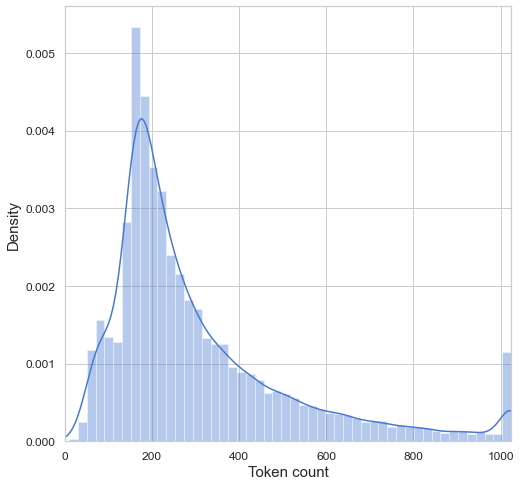

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 1024])
plt.xlabel('Token count');

In [ ]:
# max length of words in one review
df.review.str.split().apply(len).max()

2470

In [9]:
# arbitrary number based on the max token count,
# avoiding long reviews...
MAX_LEN = 512

In [16]:
encoding = tokenizer(sample_txt,
                     padding='max_length',
                     truncation=True,
                     max_length=MAX_LEN,
                     return_tensors="pt")

In [17]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

## Dataset and DataLoader

In [10]:
from torch import nn
from torch.utils.data import Dataset, DataLoader

class ReviewDataset(Dataset):
    def __init__(self, reviews, sentiments, tokenizer, max_len):
        self.reviews = reviews
        self.sentiments = sentiments
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, item):
        review = str(self.reviews[item])
        sentiment = self.sentiments[item]
        
        encoding = tokenizer(review,
                             padding='max_length',
                             truncation=True,
                             max_length=self.max_len,
                             return_tensors="pt")
        
        return {
            'review': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(sentiment, dtype=torch.long)
        }

In [15]:
ds = ReviewDataset(
    reviews=df.review.to_numpy(),
    sentiments=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)
ds[0].keys()

dict_keys(['review', 'input_ids', 'attention_mask', 'targets'])

In [16]:
df_train, df_test = train_test_split(df,
                                     test_size=0.2,
                                     stratify=df.sentiment.values,
                                     random_state=42
                                    )
df_val, df_test = train_test_split(df_test,
                                   test_size=0.5,
                                   stratify=df_test.sentiment.values,
                                   random_state=42
                                  )
df_train.shape, df_val.shape, df_test.shape

((40000, 2), (5000, 2), (5000, 2))

In [17]:
df_train.sentiment.value_counts(), df_val.sentiment.value_counts(), df_test.sentiment.value_counts()

(0    20000
 1    20000
 Name: sentiment, dtype: int64,
 0    2500
 1    2500
 Name: sentiment, dtype: int64,
 0    2500
 1    2500
 Name: sentiment, dtype: int64)

In [18]:
def create_dl(df, tokenizer, max_len, batch_size):
    ds = ReviewDataset(
        reviews=df.review.to_numpy(),
        sentiments=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size
    )

In [19]:
BATCH_SIZE = 32

train_data_loader = create_dl(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_dl(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_dl(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [20]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review', 'input_ids', 'attention_mask', 'targets'])

In [44]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32])


In [45]:
encoding = tokenizer(data['review'],
                     padding='max_length',
                     truncation=True,
                     max_length=MAX_LEN,
                     return_tensors="pt")

In [46]:
vocab = tokenizer.get_vocab()
len(vocab)

30522

In [47]:
inv_voc = {v: k for k, v in vocab.items()}

In [48]:
list(inv_voc.items())[:5]

[(23355, '##tized'),
 (26881, 'cynical'),
 (11022, '##ase'),
 (5908, 'divisions'),
 (29494, 'accelerating')]

In [51]:
data['review'][0]

'I caught this little gem totally by accident back in 1980 or \'81. I was at a revival theatre to see two old silly sci-fi movies. The theatre was packed full and (with no warning) they showed a bunch of sci-fi short spoofs (to get us in the mood). Most were somewhat amusing but THIS came on and, within seconds, the audience was in hysterics! The biggest laugh came when they showed "Princess Laia" having huge cinnamon buns instead of hair on her head. She looks at the camera, gives a grim smile and nods. That made it even funnier! You gotta see "Chewabacca" played by what looks like a Muppet! It was extremely silly and stupid...but I couldn\'t stop laughing. Most of the dialogue was drowned out because of all the laughter. Also if you know "Star Wars" pretty well it\'s even funnier--they deliberately poke fun at some of the dialogue. This REALLY works with an audience! A definite 10!'

In [49]:
" ".join(inv_voc[i] for i in encoding["input_ids"][0].numpy())

'[CLS] i caught this little gem totally by accident back in 1980 or \' 81 . i was at a revival theatre to see two old silly sci - fi movies . the theatre was packed full and ( with no warning ) they showed a bunch of sci - fi short sp ##oof ##s ( to get us in the mood ) . most were somewhat amusing but this came on and , within seconds , the audience was in h ##yst ##eric ##s ! the biggest laugh came when they showed " princess lai ##a " having huge cinnamon bun ##s instead of hair on her head . she looks at the camera , gives a grim smile and nods . that made it even fun ##nier ! you gotta see " chew ##aba ##cca " played by what looks like a mu ##ppet ! it was extremely silly and stupid . . . but i couldn \' t stop laughing . most of the dialogue was drowned out because of all the laughter . also if you know " star wars " pretty well it \' s even fun ##nier - - they deliberately poke fun at some of the dialogue . this really works with an audience ! a definite 10 ! [SEP] [PAD] [PAD] [

# DistilBert Model building

In [ ]:
from transformers import AutoModel

model = AutoModel.from_pretrained(PRETRAINED_MODEL_NAME)

In [ ]:
output = model(**encoding)

In [ ]:
print(dir(output))

['__annotations__', '__class__', '__contains__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__post_init__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'attentions', 'clear', 'copy', 'fromkeys', 'get', 'hidden_states', 'items', 'keys', 'last_hidden_state', 'move_to_end', 'pop', 'popitem', 'setdefault', 'to_tuple', 'update', 'values']


In [ ]:
output['last_hidden_state'].shape

torch.Size([1, 512, 768])

In [ ]:
output[0].shape

torch.Size([1, 512, 768])

In [ ]:
output[0][:, 0].shape

torch.Size([1, 768])

In [ ]:
model.config.hidden_size

768

In [6]:
from transformers import AutoConfig, AutoModel

class DistilBert(nn.Module):

    def __init__(self, pretrained_model_name=PRETRAINED_MODEL_NAME, num_classes=2):
        super().__init__()
        config = AutoConfig.from_pretrained(pretrained_model_name)

        self.distilbert = AutoModel.from_pretrained(pretrained_model_name,
                                                    config=config)
        self.pre_classifier = nn.Linear(config.dim, config.dim)
        self.dropout = nn.Dropout(config.seq_classif_dropout)
        self.out = nn.Linear(config.dim, num_classes)

    def forward(self, input_ids, attention_mask=None, head_mask=None):
        assert attention_mask is not None, "attention mask is none"
        
        model_output = self.distilbert(input_ids=input_ids,
                                       attention_mask=attention_mask,
                                       head_mask=head_mask)
        hidden_state = model_output[0]  # [BATCH_SIZE=BS, MAX_SEQ_LENGTH = 512, DIM = 768]
        # get the first token as pooled_output
        pooled_output = hidden_state[:, 0]  # [BS, 768]
        pooled_output = self.pre_classifier(pooled_output)  # [BS, 768]
        pooled_output = F.relu(pooled_output)  # [BS, 768]
        pooled_output = self.dropout(pooled_output)  # [BS, 768]
        output = self.out(pooled_output)  # [BS, 2]

        return output

In [21]:
device = torch.device('cuda')

In [ ]:
model = DistilBert(num_classes=2)
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
targets = data['targets'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 512])
torch.Size([32, 512])


In [ ]:
with torch.no_grad():
    output = model(input_ids, attention_mask)
    print(torch.max(F.softmax(output.detach(), dim=1), dim=1))

torch.return_types.max(
values=tensor([0.9933, 0.9976, 0.8964, 0.9661, 0.9438, 0.9659, 0.9898, 0.9945, 0.9971,
        0.9975, 0.9948, 0.9976, 0.9941, 0.9966, 0.9976, 0.9975, 0.9973, 0.9829,
        0.9976, 0.9843, 0.9962, 0.9941, 0.9879, 0.9977, 0.9973, 0.9966, 0.9974,
        0.9962, 0.9615, 0.9960, 0.9967, 0.9969], device='cuda:0'),
indices=tensor([1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
        0, 0, 1, 1, 1, 0, 1, 0], device='cuda:0'))


In [ ]:
output.shape

torch.Size([32, 2])

In [ ]:
output[:5]

tensor([[-2.5606,  2.4417],
        [ 2.9389, -3.1003],
        [ 1.0104, -1.1470],
        [ 1.6579, -1.6921],
        [-1.4521,  1.3682]], device='cuda:0')

In [ ]:
a, b = torch.max(output, dim=1)

In [ ]:
a, b

(tensor([2.4417, 2.9389, 1.0104, 1.6579, 1.3682, 1.6101, 2.2020, 2.5188, 2.8211,
         2.8911, 2.5335, 2.9332, 2.4776, 2.7414, 2.8970, 2.9071, 2.8740, 1.9653,
         2.9043, 2.0108, 2.7091, 2.4632, 2.1390, 2.9207, 2.8608, 2.7553, 2.8811,
         2.6817, 1.4902, 2.7288, 2.7598, 2.7828], device='cuda:0'),
 tensor([1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
         0, 0, 1, 1, 1, 0, 1, 0], device='cuda:0'))

In [ ]:
targets

tensor([1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
        0, 0, 1, 1, 1, 0, 1, 0], device='cuda:0')

In [ ]:
torch.sum(b == targets)

tensor(31, device='cuda:0')

In [ ]:
!nvidia-smi

Tue May 11 15:41:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    30W /  70W |   2450MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Training

In [79]:
from transformers import AdamW, get_linear_schedule_with_warmup

EPOCHS = 2

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [53]:
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
    ):

    model = model.train()
    losses = []
    correct_predictions = 0

    for dl in data_loader:
        input_ids = dl["input_ids"].to(device)
        attention_mask = dl["attention_mask"].to(device)
        targets = dl["targets"].to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)

        losses.append(loss.item())
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [54]:
def eval_model(
    model,
    data_loader,
    loss_fn,
    device,
    n_examples
    ):

    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for dl in data_loader:
            input_ids = dl["input_ids"].to(device)
            attention_mask = dl["attention_mask"].to(device)
            targets = dl["targets"].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
                )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

from collections import defaultdict
history = defaultdict(list)
best_acc = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
        )
    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
        )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_acc:
        torch.save(model.state_dict(), f'{PATH}//best_model_state.bin')
        best_acc = val_acc

Epoch 1/2
----------
Train loss 0.11950298546180128 accuracy 0.9603750000000001
Val   loss 0.18738937297551211 accuracy 0.9372

Epoch 2/2
----------
Train loss 0.08821934188082814 accuracy 0.9728
Val   loss 0.18738937297551211 accuracy 0.9372

CPU times: user 1h 11min 55s, sys: 6.95 s, total: 1h 12min 2s
Wall time: 1h 12min 12s


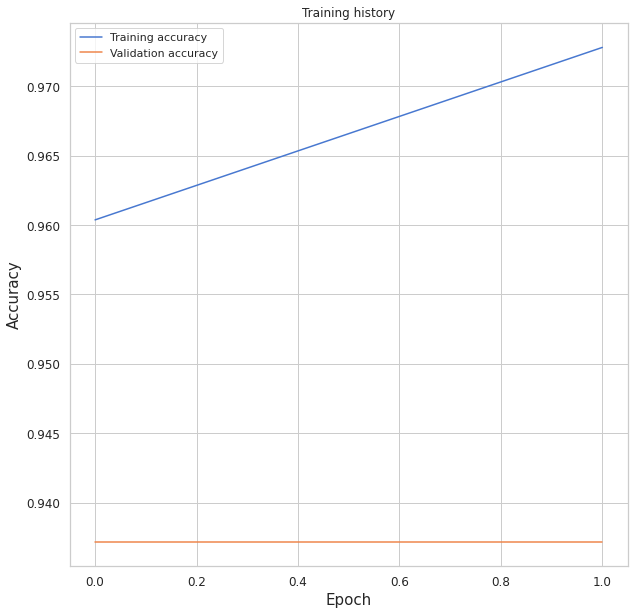

In [ ]:
plt.plot(history['train_acc'], label='Training accuracy')
plt.plot(history['val_acc'], label='Validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend();

# Evaluation

In [22]:
state_dict_path = 'data//best_model_state.bin'
class_names = ['negative', 'positive']
PRETRAINED_MODEL_NAME = 'distilbert-base-uncased'

In [24]:
model = DistilBert(PRETRAINED_MODEL_NAME, len(class_names))
model.load_state_dict(
    torch.load(state_dict_path, map_location=device)
)
model = model.to(device)
model = model.eval()

In [87]:
loss_fn = nn.CrossEntropyLoss().to(device)

In [90]:
test_acc, _ = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(df_test)
    )

test_acc.item()

0.937

In [91]:
test_acc

tensor(0.9370, device='cuda:0', dtype=torch.float64)

In [92]:
next(iter(test_data_loader)).keys()

dict_keys(['review', 'input_ids', 'attention_mask', 'targets'])

In [93]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_preds = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_preds.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_preds = torch.stack(real_preds).cpu()
  return review_texts, predictions, prediction_probs, real_preds

In [94]:
y_review, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [95]:
from sklearn.metrics import classification_report

class_names = ['negative', 'positive']
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.94      0.94      0.94      2500
    positive       0.94      0.94      0.94      2500

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000



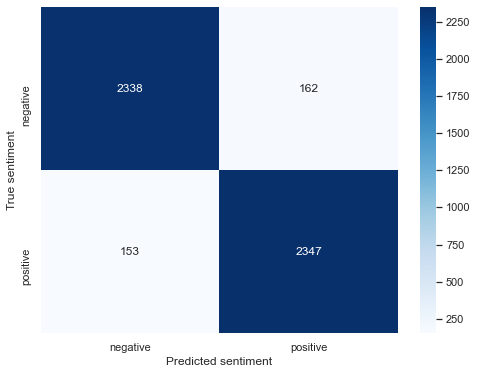

In [96]:
from sklearn.metrics import confusion_matrix

def show_confusion_matrix(confusion_matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [97]:
print(cm); display(df_cm)

[[2338  162]
 [ 153 2347]]


,negative,positive
negative,2338,162
positive,153,2347


# Predicting Random Reviews

In [101]:
import random

idx = random.randint(0, len(y_test))

review = y_review[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
    'class_names': class_names,
    'values': y_pred_probs[idx]
    })

In [102]:
from textwrap import wrap

print("\n".join(wrap(review)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

Indian cinema typifies cops of two broad categories: they are either
the honest type or the bad guys. The honest guys always shout at the
top of their voice and fight the system while the bad cops enjoy for
most part but suffer at the end.<br /><br />This movie at least breaks
this usual formula and gives a refreshing view of cops and their
lives. The direction takes an inside look at the life of a young
ambitious cop who. The music is interesting and the editing is a trend
setter as far as Indian cinema goes.<br /><br />The movie is slow at
times and the dilemma which Anbu faces when it comes to Maya is
overplayed at times. But I would still give this one 9/10 simply
because it has many firsts to its credit.

True sentiment: positive


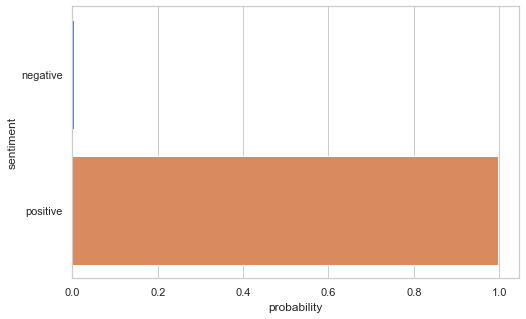

In [103]:
plt.figure(figsize=(8, 5))
sns.barplot(x='values', y='class_names', data=pred_df)
plt.ylabel('sentiment')
plt.xlabel('probability');

In [104]:
idx = random.randint(0, len(df))
review = df.review[idx]

encoded_review = tokenizer(
    review,
    padding='max_length',
    truncation=True,
    max_length=MAX_LEN,
    return_tensors="pt")

In [105]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

with torch.no_grad():
    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)

wrapped_review = "\n".join(wrap(review))
print(f'Review text: {wrapped_review}\n')
print(f'Sentiment  : {class_names[prediction]}')

Review text: This is a great family film dealing with down to earth people who
enjoy their local interests dealing mainly with horse racing. Lloyd
Bourdelle, (Walter Matthau) is a farmer who also raises quarter horses
and has a young son named Casey Bourdelle, who loves horses. Lloyd is
able to raise a full grown horse who he calls "Casey's Shadow" after
his son and this horse breaks all speed records and is a possible
winner of a million dollar race. Sarah Blue, ( Alexis Smith) becomes
interested in this horse and offers to buy the horse for $500,00
dollars, however, this horse receives serious injuries to his legs and
Lloyd receives a serious set-back which upsets the entire family.
Walter Matthau gave an outstanding performance and this is a great
film to view and enjoy.

Sentiment  : positive


# Check incorrect predictions

In [106]:
wrong_pred_idx = np.where(y_test != y_pred)[0]
len(wrong_pred_idx)

315

In [107]:
sorted(y_pred_probs[wrong_pred_idx].numpy(), key=lambda x: x.max(), reverse=True)[:5]

[array([0.00224307, 0.9977569 ], dtype=float32),
 array([0.9974662 , 0.00253376], dtype=float32),
 array([0.00263033, 0.99736965], dtype=float32),
 array([0.00267017, 0.99732983], dtype=float32),
 array([0.00270116, 0.9972989 ], dtype=float32)]

In [108]:
prob_idx_dict = {k: v.numpy() for k, v in zip(wrong_pred_idx, y_pred_probs[wrong_pred_idx])}

In [109]:
sorted_wrong_pred = sorted(prob_idx_dict.items(), 
                           key=lambda x: x[1].max(),
                           reverse=True)

In [110]:
sorted_wrong_pred[:5]

[(358, array([0.00224307, 0.9977569 ], dtype=float32)),
 (540, array([0.9974662 , 0.00253376], dtype=float32)),
 (3285, array([0.00263033, 0.99736965], dtype=float32)),
 (3566, array([0.00267017, 0.99732983], dtype=float32)),
 (4686, array([0.00270116, 0.9972989 ], dtype=float32))]

In [122]:
top_k = 5

for idx, _ in sorted_wrong_pred[:top_k]:
    wrapped_review = "\n".join(wrap(y_review[idx]))

    print(f'Review text:\n{wrapped_review}\n')
    print(f'Actual    : {class_names[y_test[idx]]}')
    print(f'Predicted : {class_names[y_pred[idx]]}\n')
    # break

Review text:
This sleek, sexy movie is a must-see. Only upon multiple viewings can
one truly understand the uniqueness of this film. Personally I enjoy
the narrator for his intelligent, no subject left untouched, style of
narration. The introduction grips you right away, and holds you at the
edge of your seat throughout the film. He provides wonderful insight
into the world of the trainables and allows the audience to really
'connect' with internal horror this film exhibits. The script itself
holds the movie together wonderfully. Not only for kids, but the
elderly alike will gain a higher understanding of the trainables and
the modern grasp that they have on the sexual experience. Ahead of its
time and groundbreaking in cinematography, it surely defines the word
'masterpiece'.

Actual    : negative
Predicted : positive

Review text:
But the opposite, sorry bud, i completely understand how you can be
dragged into a film because you relate to the subject ( and you have).
This film is ter

In [145]:
review_str = 'This sleek, sexy movie is a must-see'
df[df.review.str.contains(review_str)]

,review,sentiment
41703,"This sleek, sexy movie is a must-see. Only upo...",0


**Obviously something was wrong about the original labellings for such reviews.**

If the labels were correct, then the accuracy of the model would be much better,
as proven by the results of the predictions.